## Test robustness of classifier performance and rankings

1. With alternate training datasets - based on permutations of gene loss thresholds
2. With artificial missing data - fully imputing, in turn, the 6 features that are affected by imputation

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2, venn3, venn3_circles

import shap

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import itertools
import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs (training data and features)
file_features = get_local_data_path([],'feature_list.txt')
file_feature_names = get_local_data_path([],'feature_names.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')

# Alternate training data
file_alt_depmap_pairs = lambda expr_t, exprz_t, hdt, ess: get_local_data_path(['results','alt_params'], 
                                'depmap_pairs_expr='+str(expr_t)+'_exprz='+str(exprz_t)+'_hd='+str(hdt)+'_ess='+str(ess))
# For testing
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')
file_all_predictions = get_local_data_path(['results'], 'all_predictions.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
all_paralog_annots = pd.read_csv(file_annot_pairs)
print('Num annotated paralog pairs:', all_paralog_annots.shape[0])
all_paralog_annots[:1]

Num annotated paralog pairs: 36648


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,A1BG_OSCAR,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,...,False,False,False,False,3,210.95,0.0,False,False,False


In [3]:
features = pd.read_csv(file_features).feature.values
print('N features:', len(features))

N features: 22


In [4]:
feature_labels = pd.read_csv(file_feature_names, sep='\t')
feature_labels.loc[feature_labels.feature=='mean_complex_essentiality', 'simple_name'] = ' Essentiality of Protein Complex(es)'
feature_labels[:1]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence


In [5]:
all_preds = pd.read_csv(file_all_predictions)[['prediction_rank','sorted_gene_pair','prediction_score']]
all_preds[:1]

,prediction_rank,sorted_gene_pair,prediction_score
0,1,SMARCA2_SMARCA4,0.430886


In [6]:
consensus = pd.read_csv(file_consensus_pairs)
print('Consensus data set: %d/%d = %.2f%%' % (sum(consensus.SL), consensus.shape[0], sum(consensus.SL)/consensus.shape[0]*100))
consensus = pd.merge(pd.merge(all_preds, consensus), all_paralog_annots)
consensus[:1]

Consensus data set: 50/457 = 10.94%


,prediction_rank,sorted_gene_pair,prediction_score,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,5,CNOT7_CNOT8,0.399963,3.0,3.0,2.0,1.0,4,4,True,...,False,True,False,False,8,1628.0,0.0,False,False,False


### 1. Test alternate training data - threshold permutations
Check:
- ROC AUC and AP for screen consensus dataset
- % of top 1000 predictions that are the same
- Spearman's rank correlation between predictions from the permuted analysis and predictions from the original analysis

In [9]:
# Test with screen consensus and compare top 1000
def test_classifier(training_data, classifier, features):
    training_data = pd.merge(training_data, all_paralog_annots).sort_values(['A1','A2']).reset_index(drop=True)
    _ = classifier.fit(training_data[features], training_data.SL)
    
    ypred = classifier.predict_proba(consensus[features])[:,1]
    ROCAUC = roc_auc_score(consensus.SL, ypred)
    AP = average_precision_score(consensus.SL, ypred)
    
    newpreds = all_paralog_annots[['sorted_gene_pair']].assign(
                    new_score = classifier.predict_proba(all_paralog_annots[features])[:,1])
    newpreds = newpreds.sort_values('new_score', ascending=False).reset_index(drop=True)
    newpreds = newpreds.assign(new_rank = newpreds.index+1)
    df = pd.merge(all_preds, newpreds)
    
    top_1000_overlap = df[(df.new_rank<=1000) & (df.prediction_rank<=1000)].shape[0]
    rank_corr = stats.spearmanr(df.new_rank, df.prediction_rank)[0]
    
    return ROCAUC, AP, top_1000_overlap, rank_corr

In [10]:
thresholds = [[0.17,1],[-3,-4,-6],[-1.28,-1.5],[-0.5,-0.6,-0.7]]

In [11]:
alt_metrics = pd.DataFrame(columns=['expr','exprz','cn','ceres','n','n_SL','ROC_AUC','AP','top_1000_overlap','rank_corr'])
for i, params in enumerate(list(itertools.product(*thresholds))):
    training_data = pd.read_csv(file_alt_depmap_pairs(params[0], params[1], params[2], params[3]))
    RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.5, max_depth=3, min_samples_leaf=8)
    res = test_classifier(training_data, RF, features)
    alt_metrics.loc[i] = [params[0], params[1], params[2], params[3], training_data.shape[0], sum(training_data.SL)] + list(res)

N= 36


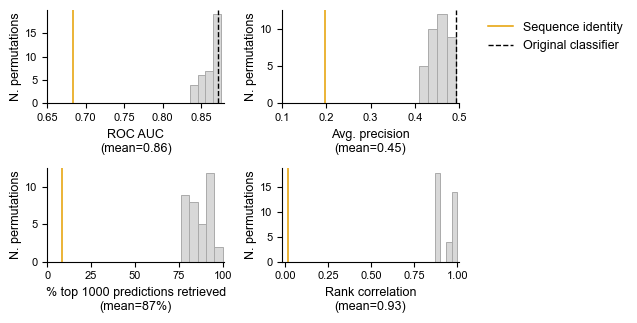

In [13]:
f, ax = plt.subplots(2, 2, figsize=(6.5,3.3)); ax=ax.flatten()
print('N=', alt_metrics.shape[0])
orig = alt_metrics[(alt_metrics.expr==1)&(alt_metrics.exprz==-4)&(alt_metrics.cn==-1.28)&(alt_metrics.ceres==-0.6)].iloc[0]

histkws = {'edgecolor':'#aaa', 'linewidth':0.7, 'color':'#ccc'}
sns.histplot(alt_metrics.ROC_AUC, ax=ax[0], **histkws, bins=4)
sns.histplot(alt_metrics.AP, ax=ax[1], **histkws, bins=4)
sns.histplot(alt_metrics.top_1000_overlap/1000*100, ax=ax[2], **histkws, bins=5)
sns.histplot(alt_metrics.rank_corr, ax=ax[3], **histkws, bins=4)
ax[0].set_xlabel('ROC AUC\n(mean=%.2f)' % (alt_metrics.ROC_AUC.mean())); 
ax[1].set_xlabel('Avg. precision\n(mean=%.2f)' % (alt_metrics.AP.mean()))
ax[2].set_xlabel('%% top 1000 predictions retrieved\n(mean=%.f%%)' % (alt_metrics.top_1000_overlap.mean()/1000*100)); 
ax[3].set_xlabel('Rank correlation\n(mean=%.2f)' % (alt_metrics.rank_corr.mean()))
for i in range(0,4): ax[i].set_ylabel('N. permutations', labelpad=2)

linekws = {'linestyle':'-', 'color':gp.get_color('orange'), 'label':'Sequence identity', 'linewidth':1.1}
ax[0].axvline(roc_auc_score(consensus.SL, consensus.min_sequence_identity), **linekws)
ax[1].axvline(average_precision_score(consensus.SL, consensus.min_sequence_identity), **linekws)

df = pd.merge(all_preds, all_paralog_annots[['sorted_gene_pair','min_sequence_identity']])
df = df.sort_values('min_sequence_identity', ascending=False)
ax[2].axvline(sum(df[:1000].prediction_rank<=1000)/1000*100, **linekws)
ax[3].axvline(stats.spearmanr(-df.min_sequence_identity, df.prediction_rank)[0], **linekws)

linekws = {'linestyle':'--', 'color':'black', 'label':'Original classifier'}
ax[0].axvline(orig.ROC_AUC, **linekws); ax[1].axvline(orig.AP, **linekws)
ax[0].set_xlim([0.65,0.88]); ax[1].set_xlim([0.1,0.5]); ax[2].set_xlim([0,101]); ax[3].set_xlim([-0.02,1.01])

_=ax[1].legend(bbox_to_anchor=(1.1,1))
plt.tight_layout()
plt.savefig("../figures/for_paper/training_data_permutation.svg", dpi=300)

### 2. Test with artificial missing data (full imputation)

In [14]:
# Load trained RF classifier from file
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

In [15]:
def compute_stats(data, RF):
    df = pd.merge(consensus[['sorted_gene_pair','SL']], data)
    ypred = RF.predict_proba(df[features])[:,1]
    ROCAUC = roc_auc_score(df.SL, ypred)
    AP = average_precision_score(df.SL, ypred)
    
    df = data[['sorted_gene_pair']].assign(new_score=RF.predict_proba(data[features])[:,1])
    df = df.sort_values('new_score', ascending=False).reset_index(drop=True)
    df = df.assign(new_rank = df.index+1)
    df = pd.merge(all_preds, df)
    top_1000 = df[(df.new_rank<=1000) & (df.prediction_rank<=1000)].shape[0]
    rank_corr = stats.spearmanr(df.new_rank, df.prediction_rank)[0]
    
    return ROCAUC, AP, top_1000, rank_corr

In [16]:
impute_results = pd.DataFrame(columns=['ROCAUC', 'AP', 'top_1000_overlap','rank_corr'])

# 1. Complex essentiality
mean_val = all_paralog_annots[all_paralog_annots.either_in_complex & ~all_paralog_annots.self_complex_only &
                              ~all_paralog_annots.flag_missing_scores].mean_complex_essentiality.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(
    mean_complex_essentiality= all_paralog_annots.apply(
        lambda x: mean_val if x.either_in_complex and not x.self_complex_only else 0, axis=1))
res = compute_stats(data, RF)
impute_results.loc['Essentiality of Protein Complex(es)'] = res

# 2. Essentiality of shared PPIs
mean_val = all_paralog_annots[all_paralog_annots.n_shared_ppi>0].shared_ppi_mean_essentiality.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(
    shared_ppi_mean_essentiality = all_paralog_annots.apply(lambda x: mean_val if x.n_shared_ppi>0 else 0, axis=1))
res = compute_stats(data, RF)
impute_results.loc['Essentiality of Shared PPIs'] = res

# 3. Mean age
mean_val = all_paralog_annots.mean_age.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(mean_age = mean_val)
res = compute_stats(data, RF)
impute_results.loc['Gene Age'] = res

# 4. Expr correlation
mean_val = all_paralog_annots.gtex_spearman_corr.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(gtex_spearman_corr = mean_val)
res = compute_stats(data, RF)
impute_results.loc['Expression Correlation'] = res

# 5. Min mean expr
mean_val = all_paralog_annots.gtex_min_mean_expr.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(gtex_min_mean_expr = mean_val)
res = compute_stats(data, RF)
impute_results.loc['Mean expression (Lower)'] = res

# 6. Max mean expr
mean_val = all_paralog_annots.gtex_max_mean_expr.mean()
print('Mean val:', mean_val)
data = all_paralog_annots.assign(gtex_max_mean_expr = mean_val)
res = compute_stats(data, RF)
impute_results.loc['Mean expression (Higher)'] = res

Mean val: 0.1986149116161616
Mean val: 0.20604555888520595
Mean val: 591.642738010096
Mean val: 0.3022725057574765
Mean val: 9.267410512851995
Mean val: 48.22846885218839


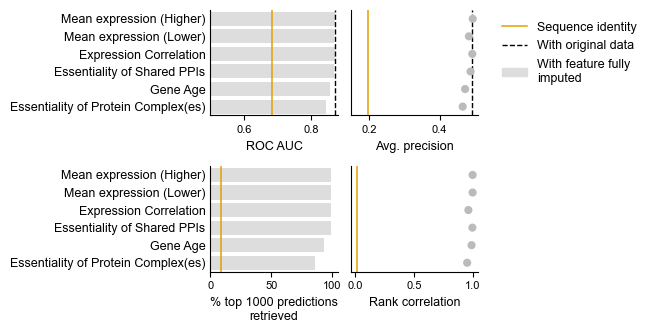

In [18]:
f, ax = plt.subplots(2, 2, figsize=(6.7,3.4), sharey=True); ax=ax.flatten()
df = impute_results.sort_values('top_1000_overlap', ascending=False)
df['top_1000_overlap'] = df.top_1000_overlap/1000*100

df.ROCAUC.plot.barh(ax=ax[0], width=0.8, color='#ddd')
#df.AP.plot.barh(ax=ax[1], width=0.8, color='#ccc')
sns.pointplot(y=df.index, x=df.AP, ax=ax[1], color='#bbb', join=False)
df.top_1000_overlap.plot.barh(ax=ax[2], width=0.8, color='#ddd')
sns.pointplot(y=df.index, x=df.rank_corr, ax=ax[3], color='#bbb', join=False)

linekws = {'linestyle':'-', 'color':gp.get_color('orange'), 'label':'Sequence identity', 'linewidth':1.1}
ax[0].axvline(roc_auc_score(consensus.SL, consensus.min_sequence_identity), **linekws)
ax[1].axvline(average_precision_score(consensus.SL, consensus.min_sequence_identity), **linekws)
linekws = {'linestyle':'--', 'color':'black', 'label':'With original data'}
ax[0].axvline(roc_auc_score(consensus.SL, consensus.prediction_score), **linekws)
ax[1].axvline(average_precision_score(consensus.SL, consensus.prediction_score), **linekws, zorder=0)

df2 = pd.merge(all_preds, all_paralog_annots[['sorted_gene_pair','min_sequence_identity']])
df2 = df2.sort_values('min_sequence_identity', ascending=False)
linekws = {'linestyle':'-', 'color':gp.get_color('orange'), 'label':'Sequence identity', 'linewidth':1.1}
ax[2].axvline(sum(df2[:1000].prediction_rank<=1000)/1000*100, **linekws)
ax[3].axvline(stats.spearmanr(-df2.min_sequence_identity, df2.prediction_rank)[0], **linekws)

gp.set_axis_props(ax[0], show_yticks=False, ytick_fontsize=9, xlabel='ROC AUC')
gp.set_axis_props(ax[1], show_yticks=False, xlabel='Avg. precision')
gp.set_axis_props(ax[2], show_yticks=False, ytick_fontsize=9, xlabel='% top 1000 predictions\nretrieved')
gp.set_axis_props(ax[3], show_yticks=False, xlabel='Rank correlation')
ax[0].set_xlim([0.5,0.88]); ax[1].set_xlim([0.15,0.51])

handles, labels = ax[1].get_legend_handles_labels()
patch = mpatches.Patch(color='#ddd', label='With feature fully\nimputed')
handles.append(patch) 
_ = ax[1].legend(handles=handles, bbox_to_anchor=(1.1,1))
plt.tight_layout()
plt.savefig("../figures/for_paper/imputation_impact.svg", dpi=300)